In [1]:
!pip3 install imbalanced-learn -q
!pip3 install fpdf -q


[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip

[notice] A new release of pip is available: 25.0.1 -> 25.1.1
[notice] To update, run: pip3 install --upgrade pip


In [2]:
import pandas as pd
import plotly.graph_objs as go
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.subplots as sp
from scipy.stats import shapiro
from sklearn.model_selection import train_test_split
import json
from imblearn.over_sampling import ADASYN
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score

import shap
from fpdf import FPDF
import joblib

In [3]:
# Load data
df = pd.read_csv('../data/credit_scoring.csv')

# Drop kolom leakage
leak_cols = ['leak_col_good', 'leak_col_subtle']
df_clean = df.drop(columns=leak_cols)

# Drop application_id (tidak informatif untuk prediksi)
df_clean = df_clean.drop(columns=['application_id'])

df_clean

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
0,41,13995609,5982664,0,624,0
1,58,13683833,3711198,0,809,0
2,33,9417391,7172332,0,647,0
3,45,6861811,8661056,0,450,0
4,22,5640742,4520669,1,816,0
...,...,...,...,...,...,...
5995,26,18253018,3690565,2,729,0
5996,40,9944385,4082038,1,477,0
5997,28,9048532,14760384,0,450,0
5998,51,6843160,11774594,0,561,0


In [4]:
# Melihat tipe data dan null data

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype
---  ------             --------------  -----
 0   age                6000 non-null   int64
 1   monthly_income     6000 non-null   int64
 2   loan_amount        6000 non-null   int64
 3   previous_defaults  6000 non-null   int64
 4   credit_score       6000 non-null   int64
 5   default            6000 non-null   int64
dtypes: int64(6)
memory usage: 281.4 KB


In [5]:
df_clean.describe()

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
count,6000.000000,6.000000e+03,6.000000e+03,6000.000000,6000.000000,6000.000000
mean,40.321500,1.140386e+07,8.001122e+06,0.243667,575.979833,0.012167
std,11.300697,4.912598e+06,4.071786e+06,0.484767,158.328931,0.109639
min,21.000000,3.000310e+06,1.000794e+06,0.000000,300.000000,0.000000
25%,31.000000,7.163379e+06,4.440939e+06,0.000000,438.750000,0.000000
50%,41.000000,1.129945e+07,7.982304e+06,0.000000,577.500000,0.000000
75%,50.000000,1.573705e+07,1.153144e+07,0.000000,713.000000,0.000000
max,59.000000,1.998622e+07,1.499858e+07,3.000000,849.000000,1.000000


## SPLITING DATA

In [6]:
# Tahap 1: Split 80% ke train, 20% ke sisa (val+test)
df_train, df_temp = train_test_split(
    df_clean, test_size=0.2, stratify=df_clean['default'], random_state=42
)

# Tahap 2: Split sisa (20%) menjadi 10% validasi, 10% test
df_val, df_test = train_test_split(
    df_temp, test_size=0.5, stratify=df_temp['default'], random_state=42
)

# Hasil akhir:
print(f"Train set    : {df_train.shape[0]} rows")
print(f"Validation   : {df_val.shape[0]} rows")
print(f"Test set     : {df_test.shape[0]} rows\n")

# Cek distribusi target di tiap subset
print(f"Proporsi default (Train):      {df_train['default'].mean():.4f}")
print(f"Proporsi default (Validation): {df_val['default'].mean():.4f}")
print(f"Proporsi default (Test):       {df_test['default'].mean():.4f}")

Train set    : 4800 rows
Validation   : 600 rows
Test set     : 600 rows

Proporsi default (Train):      0.0121
Proporsi default (Validation): 0.0133
Proporsi default (Test):       0.0117


## EDA

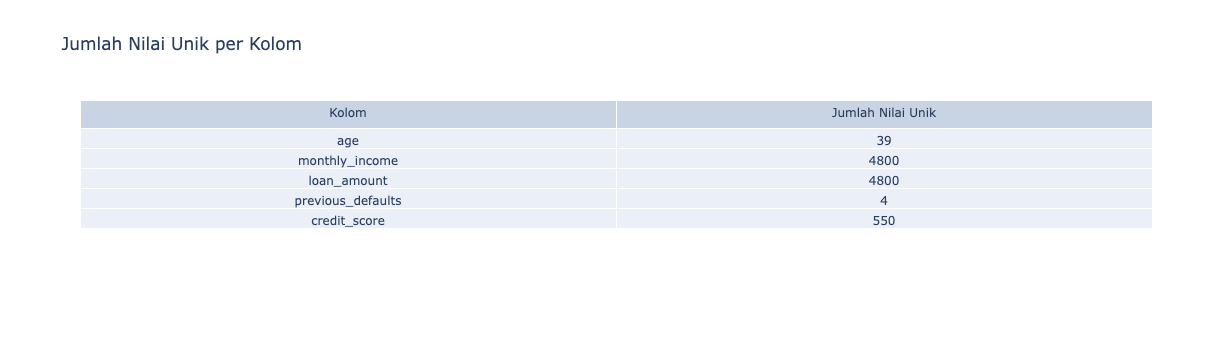

In [7]:
# Pilih kolom numerik utama
columns = ['age', 'monthly_income', 'loan_amount', 'previous_defaults', 'credit_score']

# Hitung jumlah nilai unik
unique_counts = [df_train[col].nunique() for col in columns]

# Buat tabel interaktif
fig = go.Figure(data=[go.Table(
    header=dict(values=['Kolom', 'Jumlah Nilai Unik']),
    cells=dict(values=[columns, unique_counts])
)])

fig.update_layout(title='Jumlah Nilai Unik per Kolom')
fig.show()

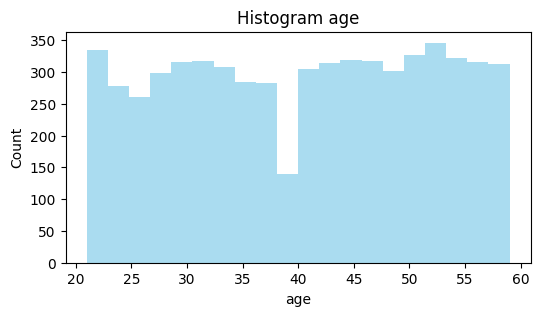

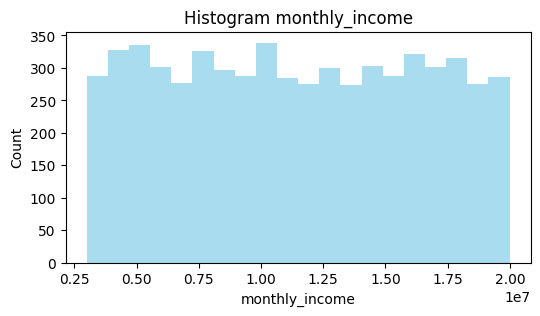

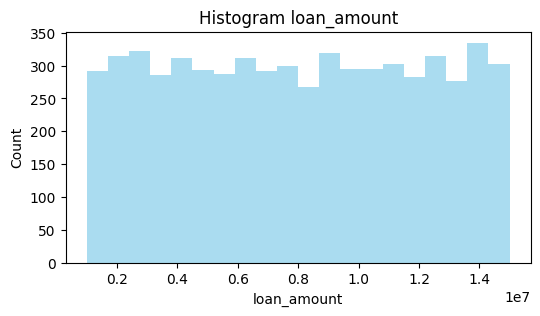

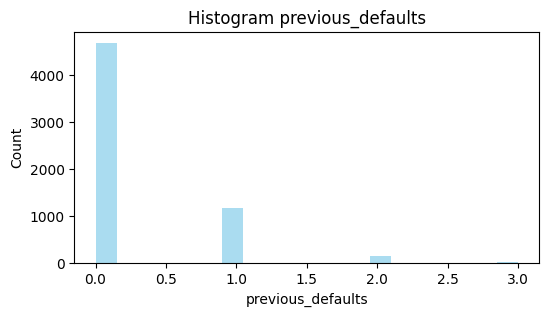

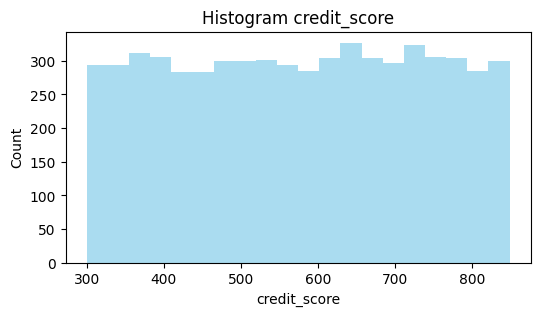

In [8]:
# Melihat distribusi tiap kolom dengan histogram

num_cols = df_train.select_dtypes(include='number').columns.tolist()
num_cols.remove('default')  # tidak usah target

for col in num_cols:
    plt.figure(figsize=(6, 3))
    plt.hist(df_clean[col], bins=20, alpha=0.7, color='skyblue')
    plt.title(f'Histogram {col}')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.show()

In [9]:
# Uji kenormalan data dengan Shapiro

for feature in ['age', 'monthly_income', 'loan_amount', 'credit_score']:
    stat, p = shapiro(df_train[feature].sample(500, random_state=42))  # Max 500 sample (Shapiro limit)
    print(f'{feature} | p-value: {p:.5f} | {"Normal" if p>0.05 else "Tidak normal"}')

age | p-value: 0.00000 | Tidak normal
monthly_income | p-value: 0.00000 | Tidak normal
loan_amount | p-value: 0.00000 | Tidak normal
credit_score | p-value: 0.00000 | Tidak normal


In [10]:
# Lihat skala apakah sudah tepat 300-850

min_score = df_train['credit_score'].min()
max_score = df_train['credit_score'].max()

print(f'Nilai terendah credit_score: {min_score}')
print(f'Nilai tertinggi credit_score: {max_score}')

Nilai terendah credit_score: 300
Nilai tertinggi credit_score: 849


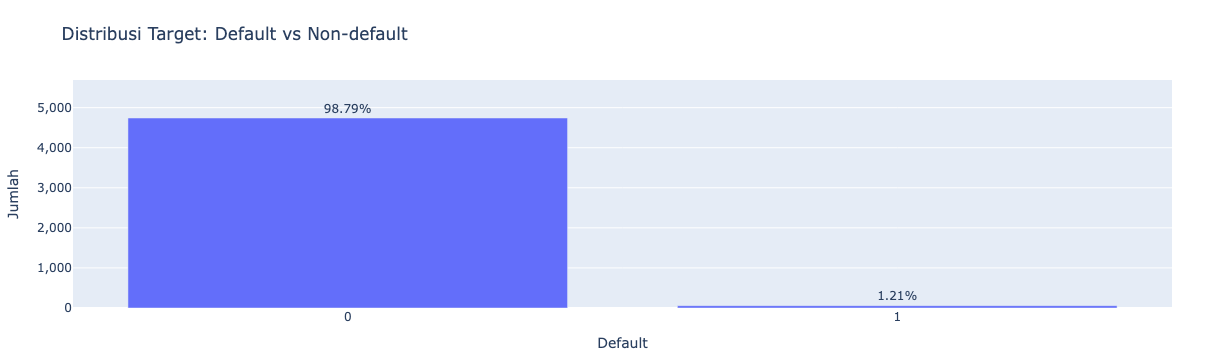

In [11]:
# Data untuk plot
default_counts = df_train['default'].value_counts()
default_pct = df_train['default'].value_counts(normalize=True) * 100

fig = px.bar(
    x=default_counts.index.astype(str),
    y=default_counts.values,
    text=[f'{p:.2f}%' for p in default_pct],
    labels={'x': 'Default', 'y': 'Jumlah'},
    title='Distribusi Target: Default vs Non-default'
)

# Supaya label tidak terpotong:
fig.update_traces(textposition='outside')
fig.update_layout(
    yaxis=dict(tickformat=',d', range=[0, default_counts.max() * 1.2]),  # yaxis dinaikkan
    margin=dict(t=80, b=40, l=60, r=60)  # Tambah margin atas/bawah/kiri/kanan
)

fig.show()

#### ASUMSI

##### - Default adalah target label:
###### 1 = gagal bayar (default)
###### 0 = tidak gagal bayar (tidak default)

##### - previous_defaults adalah jumlah kegagalan bayar di masa lalu (di pinjaman sebelumnya, bisa 0, 1, 2, atau 3 kali).

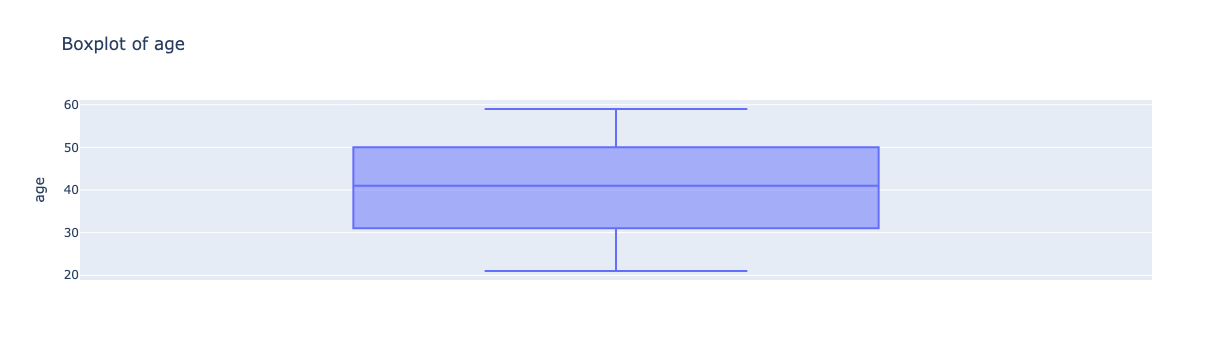

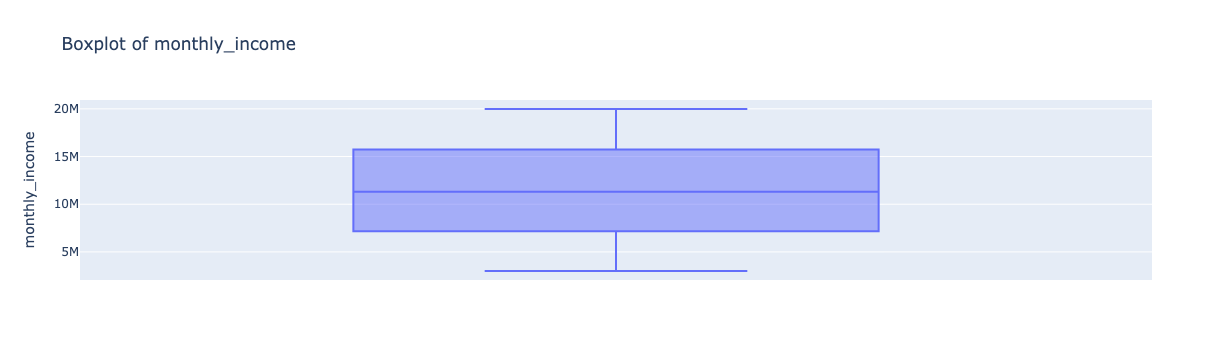

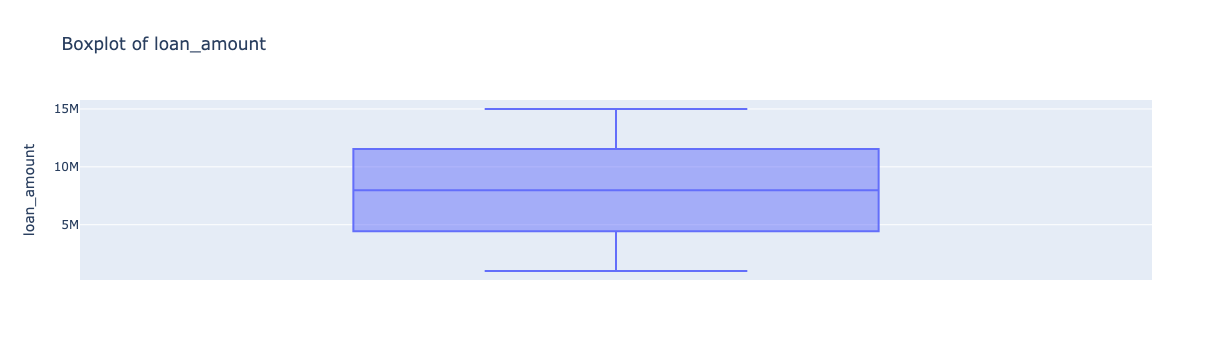

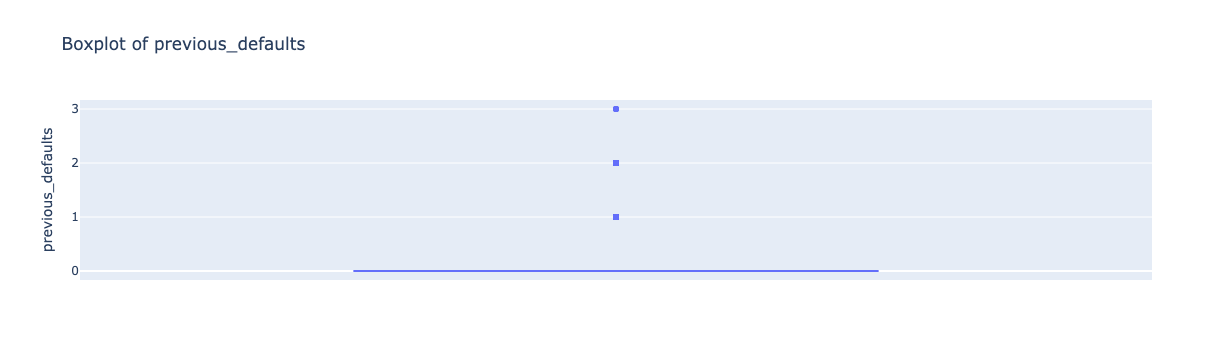

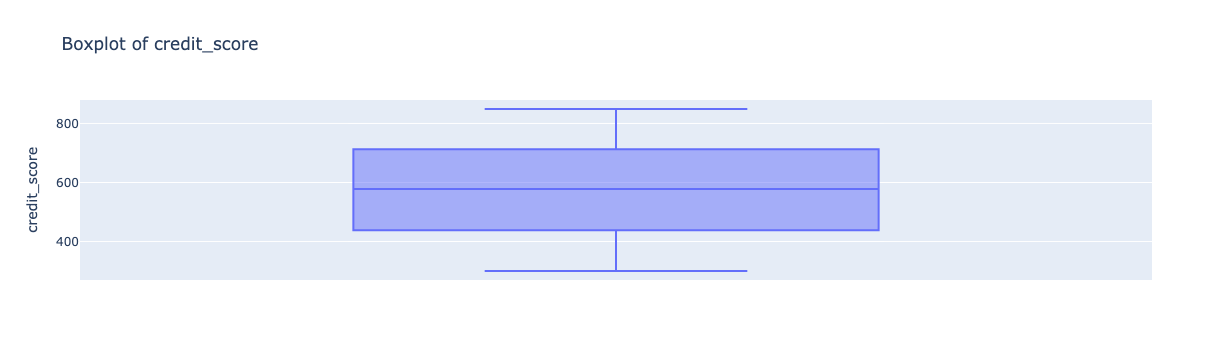

In [12]:
# Cek outlier dengan boxplot

# Loop boxplot untuk setiap fitur numerik (kecuali target)
num_cols = df_train.select_dtypes(include='number').columns.tolist()
num_cols.remove('default')

for col in num_cols:
    fig = px.box(df_clean, y=col, title=f'Boxplot of {col}')
    fig.show()

In [13]:
# Presentase outlier

for col in num_cols:
    Q1 = df_train[col].quantile(0.25)
    Q3 = df_train[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    n_out = ((df_clean[col] < lower_bound) | (df_clean[col] > upper_bound)).sum()
    print(f'{col}: {n_out} outlier ({n_out/len(df_clean)*100:.2f}%)')

age: 0 outlier (0.00%)
monthly_income: 0 outlier (0.00%)
loan_amount: 0 outlier (0.00%)
previous_defaults: 1314 outlier (21.90%)
credit_score: 0 outlier (0.00%)


In [14]:
df_train.corr()

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
age,1.000000,-0.013844,0.009990,-0.006814,0.007558,0.001169
monthly_income,-0.013844,1.000000,-0.007674,0.013885,0.013466,-0.062206
loan_amount,0.009990,-0.007674,1.000000,0.007415,0.025951,0.074503
previous_defaults,-0.006814,0.013885,0.007415,1.000000,0.005384,0.053876
credit_score,0.007558,0.013466,0.025951,0.005384,1.000000,-0.064042
default,0.001169,-0.062206,0.074503,0.053876,-0.064042,1.000000


## Data Preprocessing

In [15]:
# SCALING TRAIN

# Tentukan kolom numerik yang akan discaling (tanpa kolom target)
num_cols = ['age', 'monthly_income', 'loan_amount', 'previous_defaults']

# Fit scaler di data training
scaler = StandardScaler()
scaler.fit(df_train[num_cols])

# Transformasi semua set (pakai scaler dari train!)
df_train[num_cols] = scaler.transform(df_train[num_cols])
df_val[num_cols] = scaler.transform(df_val[num_cols])

#### Kolom credit_score tidak digunakna karena diasumsikan jika ada pelanggan baru tidak mungkin ada nilai credit score nya karena ini yang akan dicari setelah prediksi dilakukan

In [16]:
# Inbalance Handling menggunakan ADASYN

# Misal df_train sudah diproses dan punya kolom target 'default'
X_train = df_train.drop(columns=['default', 'credit_score'])
y_train = df_train['default']

# Oversampling dengan ADASYN
adasyn = ADASYN(random_state=42, n_neighbors=5)
X_res, y_res = adasyn.fit_resample(X_train, y_train)

print('Sebelum oversampling:')
print(y_train.value_counts())
print('\nSetelah ADASYN oversampling:')
print(y_res.value_counts())

Sebelum oversampling:
default
0    4742
1      58
Name: count, dtype: int64

Setelah ADASYN oversampling:
default
1    4743
0    4742
Name: count, dtype: int64


## TRAIN AND VALIDATION

### Logistic Regression

In [17]:
X_val = df_val.drop(columns=['default', 'credit_score'])
y_val = df_val['default']

# --- Fit model ---
base_model = LogisticRegression(random_state=42, max_iter=1000)
base_model.fit(X_res, y_res)

# --- TRAIN SET ---
y_train_prob = base_model.predict_proba(X_res)[:, 1]
y_train_pred = (y_train_prob >= 0.65).astype(int)

print("=== TRAIN SET ===")
print(classification_report(y_res, y_train_pred))
print("AUC Train:", roc_auc_score(y_res, y_train_prob))

# --- VALIDATION SET ---
y_val_prob = base_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_prob >= 0.65).astype(int)

print("\n=== VALIDATION SET ===")
print(classification_report(y_val, y_val_pred))
print("AUC Validation:", roc_auc_score(y_val, y_val_prob))

=== TRAIN SET ===
              precision    recall  f1-score   support

           0       0.64      0.85      0.73      4742
           1       0.77      0.52      0.62      4743

    accuracy                           0.68      9485
   macro avg       0.71      0.68      0.67      9485
weighted avg       0.71      0.68      0.67      9485

AUC Train: 0.7673200035604868

=== VALIDATION SET ===
              precision    recall  f1-score   support

           0       0.99      0.87      0.93       592
           1       0.04      0.38      0.07         8

    accuracy                           0.86       600
   macro avg       0.51      0.62      0.50       600
weighted avg       0.98      0.86      0.91       600

AUC Validation: 0.6492820945945946


### Gradient Boosting

In [18]:
# --- Fit model ---
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_res, y_res)

# --- TRAIN SET ---
y_train_prob = gb_model.predict_proba(X_res)[:, 1]
y_train_pred = (y_train_prob >= 0.65).astype(int)

print("=== TRAIN SET (Gradient Boosting) ===")
print(classification_report(y_res, y_train_pred))
print("AUC Train:", roc_auc_score(y_res, y_train_prob))

# --- VALIDATION SET ---
y_val_prob = gb_model.predict_proba(X_val)[:, 1]
y_val_pred = (y_val_prob >= 0.65).astype(int)

print("\n=== VALIDATION SET (Gradient Boosting) ===")
print(classification_report(y_val, y_val_pred))
print("AUC Validation:", roc_auc_score(y_val, y_val_prob))

=== TRAIN SET (Gradient Boosting) ===
              precision    recall  f1-score   support

           0       0.80      0.92      0.86      4742
           1       0.90      0.78      0.83      4743

    accuracy                           0.85      9485
   macro avg       0.85      0.85      0.85      9485
weighted avg       0.85      0.85      0.85      9485

AUC Train: 0.9400664639038747

=== VALIDATION SET (Gradient Boosting) ===
              precision    recall  f1-score   support

           0       0.99      0.91      0.95       592
           1       0.04      0.25      0.06         8

    accuracy                           0.90       600
   macro avg       0.51      0.58      0.50       600
weighted avg       0.98      0.90      0.94       600

AUC Validation: 0.6510768581081081


## Testing

In [19]:
# SCALING TEST

# Tentukan kolom numerik yang akan discaling (tanpa kolom target)
num_cols = ['age', 'monthly_income', 'loan_amount', 'previous_defaults']

df_test[num_cols] = scaler.transform(df_test[num_cols])

In [20]:
# Siapkan data test
X_test = df_test.drop(columns=['default', 'credit_score'])
y_test = df_test['default']

# Prediksi probabilitas pada test set
y_test_prob = base_model.predict_proba(X_test)[:, 1]

# Gunakan threshold 0.6 untuk klasifikasi
y_test_pred = (y_test_prob >= 0.65).astype(int)

# Evaluasi
print("=== TEST SET ===")
print(classification_report(y_test, y_test_pred))
print("AUC Test:", roc_auc_score(y_test, y_test_prob))

=== TEST SET ===
              precision    recall  f1-score   support

           0       0.99      0.84      0.91       593
           1       0.03      0.43      0.06         7

    accuracy                           0.84       600
   macro avg       0.51      0.64      0.49       600
weighted avg       0.98      0.84      0.90       600

AUC Test: 0.7318718381112985


In [21]:
# Siapkan data test
X_test = df_test.drop(columns=['default', 'credit_score'])
y_test = df_test['default']

# Prediksi probabilitas pada test set
y_test_prob = gb_model.predict_proba(X_test)[:, 1]

# Gunakan threshold 0.6 untuk klasifikasi
y_test_pred = (y_test_prob >= 0.65).astype(int)

# Evaluasi
print("=== TEST SET (Gradient Boosting) ===")
print(classification_report(y_test, y_test_pred))
print("AUC Test:", roc_auc_score(y_test, y_test_prob))

=== TEST SET (Gradient Boosting) ===
              precision    recall  f1-score   support

           0       0.99      0.90      0.94       593
           1       0.02      0.14      0.03         7

    accuracy                           0.89       600
   macro avg       0.50      0.52      0.48       600
weighted avg       0.98      0.89      0.93       600

AUC Test: 0.48915923873765355


## Reporrt Model terbaik, berdasarkan nilai Recall Validation tertinggi

In [22]:
# Helper function
def get_metrics(y_true_train, y_pred_train, y_prob_train, 
                y_true_val, y_pred_val, y_prob_val, 
                y_true_test, y_pred_test, y_prob_test):
    # Precision, recall, AUC untuk train, val, test
    precision_train = precision_score(y_true_train, y_pred_train, zero_division=0)
    recall_train    = recall_score(y_true_train, y_pred_train, zero_division=0)
    auc_train       = roc_auc_score(y_true_train, y_prob_train)
    
    precision_val = precision_score(y_true_val, y_pred_val, zero_division=0)
    recall_val    = recall_score(y_true_val, y_pred_val, zero_division=0)
    auc_val       = roc_auc_score(y_true_val, y_prob_val)
    
    precision_test = precision_score(y_true_test, y_pred_test, zero_division=0)
    recall_test    = recall_score(y_true_test, y_pred_test, zero_division=0)
    auc_test       = roc_auc_score(y_true_test, y_prob_test)
    
    # Gap (%)
    gap_rec_train_val = 100 * (recall_train - recall_val) / recall_train if recall_train != 0 else 0
    gap_pre_train_val = 100 * (precision_train - precision_val) / precision_train if precision_train != 0 else 0
    gap_auc_train_val = 100 * (auc_train - auc_val) / auc_train if auc_train != 0 else 0
    
    gap_rec_train_test = 100 * (recall_train - recall_test) / recall_train if recall_train != 0 else 0
    gap_pre_train_test = 100 * (precision_train - precision_test) / precision_train if precision_train != 0 else 0
    gap_auc_train_test = 100 * (auc_train - auc_test) / auc_train if auc_train != 0 else 0

    return [precision_train, recall_train, auc_train,
            precision_val, recall_val, auc_val,
            precision_test, recall_test, auc_test,
            gap_rec_train_val, gap_pre_train_val, gap_auc_train_val,
            gap_rec_train_test, gap_pre_train_test, gap_auc_train_test]

# Data Logistic Regression (threshold 0.6)
metrics_log = get_metrics(
    y_res,
    (base_model.predict_proba(X_res)[:,1] >= 0.65).astype(int),
    base_model.predict_proba(X_res)[:,1],
    
    y_val,
    (base_model.predict_proba(X_val)[:,1] >= 0.65).astype(int),
    base_model.predict_proba(X_val)[:,1],
    
    y_test,
    (base_model.predict_proba(X_test)[:,1] >= 0.65).astype(int),
    base_model.predict_proba(X_test)[:,1],
)

# Data Gradient Boosting (threshold 0.46)
metrics_gb = get_metrics(
    y_res,
    (gb_model.predict_proba(X_res)[:,1] >= 0.65).astype(int),
    gb_model.predict_proba(X_res)[:,1],
    
    y_val,
    (gb_model.predict_proba(X_val)[:,1] >= 0.65).astype(int),
    gb_model.predict_proba(X_val)[:,1],
    
    y_test,
    (gb_model.predict_proba(X_test)[:,1] >= 0.65).astype(int),
    gb_model.predict_proba(X_test)[:,1],
)


# DataFrame
df_summary = pd.DataFrame(
    [metrics_log, metrics_gb],
    columns=[
        'Precision_train', 'Recall_train', 'AUC_train',
        'Precision_val', 'Recall_val', 'AUC_val',
        'Precision_test', 'Recall_test', 'AUC_test',
        'GapRecall_train_val(%)', 'GapPrecision_train_val(%)', 'GapAUC_train_val(%)',
        'GapRecall_train_test(%)', 'GapPrecision_train_test(%)', 'GapAUC_train_test(%)',
    ],
    index=['Logistic Regression', 'Gradient Boosting']
)

df_summary

,Precision_train,Recall_train,AUC_train,Precision_val,Recall_val,AUC_val,Precision_test,Recall_test,AUC_test,GapRecall_train_val(%),GapPrecision_train_val(%),GapAUC_train_val(%),GapRecall_train_test(%),GapPrecision_train_test(%),GapAUC_train_test(%)
Logistic Regression,0.771974,0.520346,0.767320,0.037037,0.375,0.649282,0.031579,0.428571,0.731872,27.932536,95.202293,15.383140,17.637185,95.909324,4.619737
Gradient Boosting,0.902822,0.775669,0.940066,0.035714,0.250,0.651077,0.015873,0.142857,0.489159,67.769774,96.044150,30.741401,81.582728,98.241845,47.965462


#### Model terbaik dipiih berdasarkan nilai recall tertinggi dan kestabilan model yang dilihat dari train, test, validation

In [23]:
# Best_model adalah model terbaik Logistic Regression
# Ubah nama file jika model terbaik adalah gb_model
joblib.dump(base_model, 'best_model.joblib')

print("Model terbaik berhasil disimpan ke 'best_model.joblib'")

Model terbaik berhasil disimpan ke 'best_model.joblib'


## Fungsi scorecard(prob) dan Real predict Menggunakan Logistic Regression

In [24]:
# --- Konfigurasi ---
threshold = 0.65  # threshold prediksi default
min_score, max_score = 300, 850  # skala scorecard

# --- Prediksi probabilitas default ---
y_test_prob = base_model.predict_proba(X_test)[:, 1]

# --- Fungsi Scorecard ---
def scorecard(prob, min_score=300, max_score=850):
    return (1 - prob) * (max_score - min_score) + min_score

# --- Skor credit berdasarkan probabilitas default ---
y_test_score = scorecard(y_test_prob, min_score, max_score)

# --- Inverse Scaling fitur numerik ---
X_test_inverse = X_test.copy()
X_test_inverse[num_cols] = scaler.inverse_transform(X_test[num_cols])
X_test_inverse[num_cols] = X_test_inverse[num_cols].round(0).astype(int)  # bulatkan ke integer

# --- Gabungkan semua ke satu DataFrame untuk evaluasi dan analisis ---
df_scorecard = X_test_inverse.copy()
df_scorecard['true_label'] = y_test.values
df_scorecard['pred_label'] = (y_test_prob >= threshold).astype(int)
df_scorecard['predict_proba_default'] = y_test_prob
df_scorecard['scorecard'] = y_test_score.round(3)

# --- Simpan ke CSV ---
df_scorecard.to_csv('test_pred.csv', index=False)

# --- Tampilkan hasil ---
df_scorecard

,age,monthly_income,loan_amount,previous_defaults,true_label,pred_label,predict_proba_default,scorecard
251,35,13695714,3879254,0,0,0,0.145209,770.135
5369,43,5534428,1895673,0,0,0,0.223350,727.158
2304,26,17212396,6807879,0,0,0,0.176778,752.772
4073,52,13227115,7238455,0,0,0,0.237786,719.218
1675,48,9917447,10140367,0,0,0,0.463228,595.224
...,...,...,...,...,...,...,...,...
2926,49,8479944,7391425,1,0,0,0.535790,555.315
881,37,18563790,4929983,0,0,0,0.102983,793.359
3944,44,16847622,13381584,0,1,0,0.425403,616.028
4988,23,15571773,2316142,0,0,0,0.097495,796.378


#### Nilai Score makin besar, makin mendekati 1 atau DEFAULT

## SHAP

In [25]:
# SHAP explainer
explainer = shap.Explainer(base_model, X_res)
shap_values = explainer(X_res)

# Plot SHAP summary top-10 fitur
plt.figure()
shap.plots.bar(shap_values[:, :10], show=False)  # Ambil top-10
plt.tight_layout()
plt.savefig('shap_top_all.png', dpi=300)
plt.close()

## TESTING UNTUK PEMINJAMAN 5 JUTA (SEKITAR 5 JUTAAN)

In [26]:
# 1. Pilih data debitur pinjaman sekitar 5 juta
target_nominal = 5_000_000
loan_margin = 100_000

example_df = df_clean[(df_clean['loan_amount'] >= target_nominal - loan_margin) & (df_clean['loan_amount'] <= target_nominal + loan_margin)]
if not example_df.empty:
    example = example_df.iloc[0]
    log_text = "PINJAMAN 5 JUTA - Diperlakukan khusus (analisis risiko khusus)"
else:
    idx_closest = (df_clean['loan_amount'] - target_nominal).abs().idxmin()
    example = df_clean.loc[idx_closest]
    log_text = "Pinjaman tidak persis 5 juta, menggunakan kasus terdekat."

example_df_final = pd.DataFrame([example])
example_df_final

,age,monthly_income,loan_amount,previous_defaults,credit_score,default
25,31,12871140,4999366,0,433,0


In [27]:
# --- Gunakan model terbaik: Logistic Regression ---

# SCALING TEST
# Tentukan kolom numerik yang akan discaling (tanpa kolom target)
num_cols = ['age', 'monthly_income', 'loan_amount', 'previous_defaults']

# Lakukan scaling ke data contoh
example_df_final[num_cols] = scaler.transform(example_df_final[num_cols])

# Drop target dan kolom non-feature
X_test = example_df_final.drop(columns=['default', 'credit_score'])

# Prediksi probabilitas default (kelas 1)
y_test_prob = base_model.predict_proba(X_test)[:, 1]

# Fungsi scorecard: mapping probabilitas ke skala 300-850
def scorecard(prob, min_score=300, max_score=850):
    return (1 - prob) * (max_score - min_score) + min_score

# Hitung scorecard dari probabilitas
y_test_score = scorecard(y_test_prob)

# Inverse scaling untuk interpretasi hasil akhir
X_test_inverse = X_test.copy()
X_test_inverse[num_cols] = scaler.inverse_transform(X_test[num_cols])
X_test_inverse[num_cols] = X_test_inverse[num_cols].round(0).astype(int)  # opsional: pembulatan

# Gabungkan hasil ke DataFrame akhir
df_scorecard = X_test_inverse.copy()
df_scorecard['pred_label'] = (y_test_prob >= 0.65).astype(int)  # THRESHOLD 0.6
df_scorecard['predict_proba_default'] = y_test_prob
df_scorecard['scorecard'] = y_test_score.round(3)

df_scorecard

,age,monthly_income,loan_amount,previous_defaults,pred_label,predict_proba_default,scorecard
25,31,12871140,4999366,0,0,0.195251,742.612


In [28]:
# 1. SHAP force plot untuk 1 pemohon 5 juta
shap_value_example = explainer(X_test.values)  # sudah urutan, sudah scaled

# Ambil fitur asli untuk plot
X_test_inverse = X_test.copy()
X_test_inverse[num_cols] = scaler.inverse_transform(X_test[num_cols])
X_test_inverse = X_test_inverse.astype(int)

# Force plot SHAP (PNG, fitur asli)
plt.figure(figsize=(8,2))
shap.force_plot(
    explainer.expected_value, shap_value_example.values[0], X_test_inverse.values[0],
    feature_names=X_test.columns, matplotlib=True, show=False
)
plt.tight_layout()
plt.savefig('shap_force_5juta_inverse.png', dpi=300, bbox_inches='tight')
plt.close()

# 2. Ringkasan keputusan (teks)
score = df_scorecard['scorecard'].values[0]
proba_default = df_scorecard['predict_proba_default'].values[0]
pred_label = df_scorecard['pred_label'].values[0]
status = "DITOLAK" if pred_label == 1 else "DISETUJUI"

summary = f"""Keputusan Pinjaman IDR 5 Juta
--------------------------------------------
Status Pengajuan: {status}
Scorecard: {score:.0f} (range 300-850)
Probabilitas gagal bayar: {proba_default:.2%}
{log_text}

Data Pemohon:
"""
for col in X_test_inverse.columns:
    summary += f"{col}: {X_test_inverse[col].values[0]}\n"

# Fitur terpenting dari SHAP (Top-3)
top_feats_idx = np.argsort(np.abs(shap_value_example.values[0]))[::-1][:3]
top_feats = [X_test.columns[i] for i in top_feats_idx]
summary += "\nFitur terpenting (SHAP):\n" + "\n".join(top_feats)

# 3. Generate PDF 1-halaman
pdf = FPDF()
pdf.add_page()
pdf.set_font("Arial", size=12)
for line in summary.split('\n'):
    pdf.cell(0, 8, line, ln=1)
pdf.image('shap_force_5juta_inverse.png', x=10, y=None, w=pdf.w - 20)
pdf.output("decision_slide.pdf")

print("PDF keputusan (decision_slide.pdf) berhasil dibuat.")

PDF keputusan (decision_slide.pdf) berhasil dibuat.


<Figure size 800x200 with 0 Axes>